In [1]:
import os
import platform
import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm
from utils import *
import numpy as np
import pickle
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
%matplotlib inline
sns.set_context('notebook')
sns.set_theme(style="ticks", palette="bright")
plt.style.use(['grid'])

# 设置字体
if platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
else:
    plt.rcParams['font.family'] = ['Arial Unicode MS']

# 加载数据
filepath = 'train_data.pkl'
if not os.path.exists(filepath):
    general_process(output_filepath=filepath)
with open(filepath, 'rb') as fin:
    df = pickle.load(fin)

# 验证数据处理是否正确
assert -1 < df.iloc[5242].values[-1][0] + 0.84456 < 1
assert len(df[df['flux_density'].apply(lambda x: np.isnan(x).any()) == True]) == 0

df.head(1)

,type_material,temp,freq,core_loss,type_waveform,flux_density
0,1,25,50030,1997.95525,正弦波,"[0.000212759, 0.000389496, 0.00056608, 0.00074..."


In [2]:
df.type_material.unique()

array(['1', '2', '3', '4'], dtype=object)

In [3]:
df[df['type_waveform'] == '梯形波'].head(1)

,type_material,temp,freq,core_loss,type_waveform,flux_density
2370,1,25,50060,12568.70593,梯形波,"[-0.031923941, -0.031231432, -0.030540103, -0...."


# 问题一： 励磁波形分类

输入一个长度为1024的序列，输出一个类别（正弦波1、三角波2、梯形波3）

In [4]:
# sns.displot(df['type_waveform'], shrink=0.5)

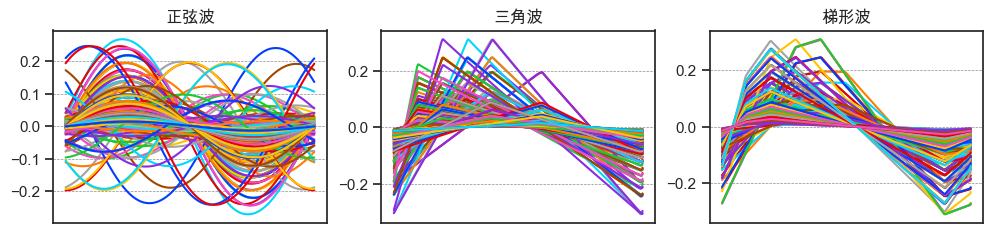

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 2.5))
xs = np.linspace(0, 1, 1024)
for type_waveform, ax in zip(['正弦波', '三角波', '梯形波'], axes):
    for i in range(1, min(10000, len(df[df['type_waveform'] == type_waveform])), 15):
        ax.plot(xs, df[df['type_waveform'] == type_waveform]['flux_density'].iloc[i])
        ax.set_title(type_waveform)
        ax.set_xticks([])

plt.savefig('figures/waveform.png', dpi=500, bbox_inches='tight')

## 标准化

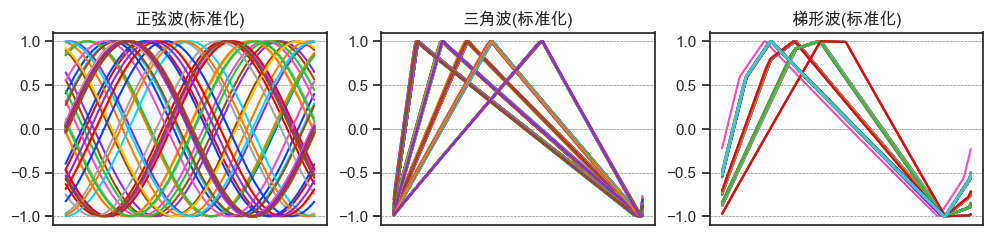

In [6]:
# 注意：问题一需要对励磁波形标准化至[-1, 1]
df['flux_density'] = df['flux_density'].apply(
    lambda x: 2 * (x - np.min(x)) / (np.max(x) - np.min(x)) - 1)

fig, axes = plt.subplots(1, 3, figsize=(12, 2.5))
for type_waveform, ax in zip(['正弦波', '三角波', '梯形波'], axes):
    hop = 30 if type_waveform == '正弦波' else 10
    for i in range(1, min(10000, len(df[df['type_waveform'] == type_waveform])), hop):
        ax.plot(xs, df[df['type_waveform'] == type_waveform]['flux_density'].iloc[i])
        ax.set_title(type_waveform + '(标准化)')
        ax.set_xticks([])

plt.savefig('figures/p1-waveform_normalized.png', dpi=500, bbox_inches='tight')

## 尝试一：傅立叶变换、时频谱图

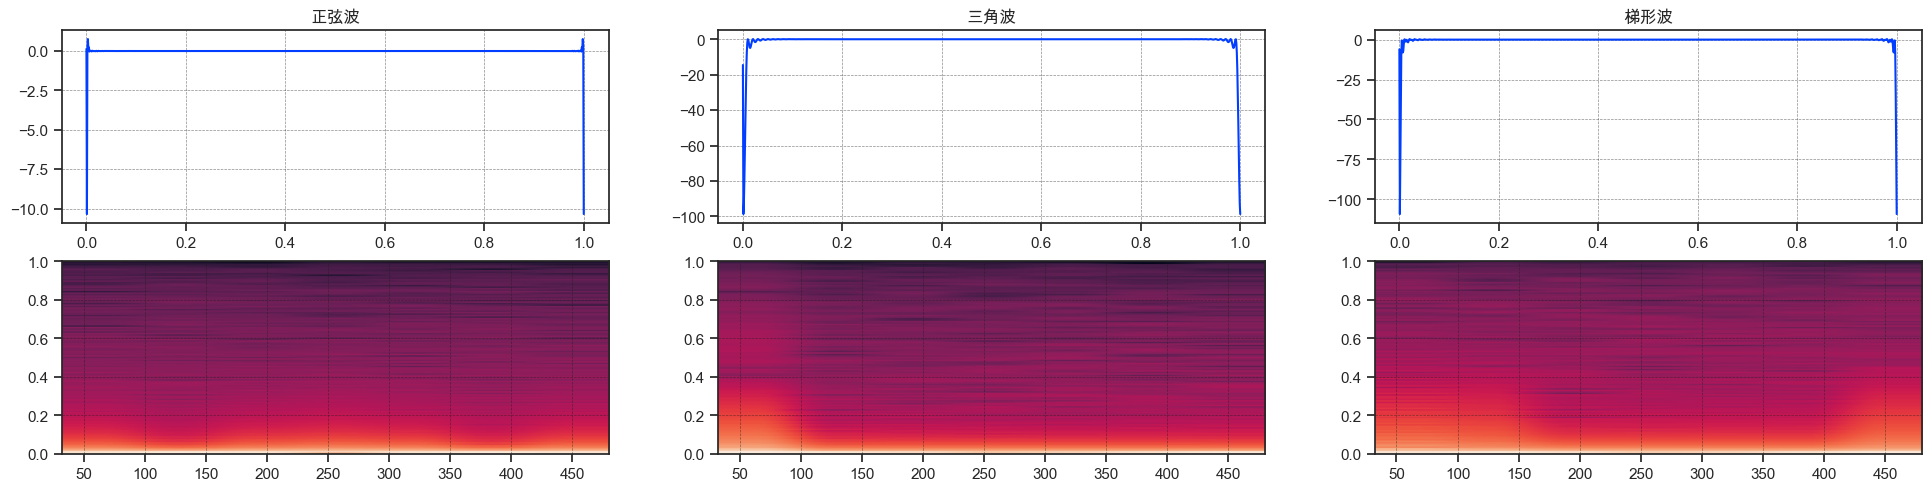

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(24, 5.5))
for type_waveform, i in zip(['正弦波', '三角波', '梯形波'], range(3)):
    ax = axes[0, i % 3]
    ax.plot(xs, np.fft.fft(df[df['type_waveform'] == type_waveform]['flux_density'].iloc[1]))
    ax.set_title(type_waveform)
    ax = axes[1, i % 3]
    ax.specgram(df[df['type_waveform'] == type_waveform]['flux_density'].iloc[1])
plt.savefig('figures/p1-fft.pdf', bbox_inches='tight')

## 尝试二：斜率变化、拐点情况（特征工程）

In [8]:
def break_counter(sequence, step=25, eps=0.05, verbose=False):
    """ count the number of the "change" 
    of the first_derivative is bigger than eps """
    first_derivative = np.diff(sequence[::step])
    # second_derivative = np.diff(first_derivative)
    pivots = []
    for j in range(len(first_derivative) - 1):
        if np.abs(first_derivative[j+1] - first_derivative[j]) > eps:
            if not pivots or j - pivots[-1] > 2:
                pivots.append(j)
    if verbose:
        print(pivots)
    return len(pivots)

In [9]:
df['break_count'] = df['flux_density'].apply(lambda x: break_counter(x))
df[(df['type_waveform'] == '三角波') & (df['break_count'] == 2)].head(1)

,type_material,temp,freq,core_loss,type_waveform,flux_density,break_count


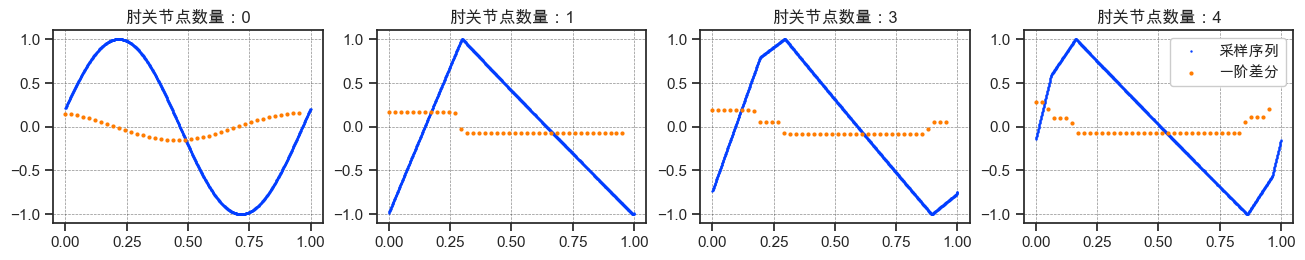

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(16, 2.5))
step = 25
for i, (type_waveform, ax) in enumerate(zip(['正弦波', '三角波', '梯形波', '梯形波'], axes)):
    sequence = df[df['type_waveform'] == type_waveform].sample(1)['flux_density'].values[0]
    if i == 3:
        sequence = df[(df['type_waveform'] == '梯形波') & (df['break_count'] == 4)].head(1)['flux_density'].values[0]
    first_derivative = np.diff(sequence[::step])
    ax.scatter(xs, sequence, label='采样序列', s=0.5)
    ax.scatter(xs[::step][:-1], first_derivative, label='一阶差分', s=4)
    # count the number of the "change" of the first_derivative is bigger than eps
    ax.set_title(f'肘关节点数量：{break_counter(sequence, step=step)}')
plt.legend()
plt.savefig('figures/p1-knee.png', dpi=600, bbox_inches='tight')

In [11]:
flag = False

# 测试：检验是否正确
for _ in tqdm(range(1_000)):
    sstep, eeps = 25, 0.05
    sequence = df[df['type_waveform'] == '正弦波'].sample(1)['flux_density'].values[0]
    assert break_counter(sequence, step=sstep, eps=eeps) == 0

    record = df[df['type_waveform'] == '三角波'].sample(1)
    sequence = record['flux_density'].iloc[0]
    break_count = break_counter(sequence, step=sstep, eps=eeps)
    if break_count not in [1, 2]:
        flag = True
        break

    record = df[df['type_waveform'] == '梯形波'].sample(1)
    sequence = record['flux_density'].iloc[0]
    break_count = break_counter(sequence, step=sstep, eps=eeps)
    if break_count not in [3, 4]:
        flag = True
        break

if flag:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    print(break_count, record)
    ax.scatter(xs, sequence, s=0.5)
    ax.scatter(xs[::step][:-1], first_derivative, s=4)
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

## 测试

特别把附件二中样本序号为：1, 5, 15, 25, 35, 45, 55, 65, 75, 80 的分类结果，以表格形式呈现在论文正文中。

In [12]:
test_df = pd.read_excel('dataset/附件二（测试集）.xlsx')
test_df.rename(columns={'0（磁通密度B，T）': 0}, inplace=True)
test_df['flux_density'] = test_df.iloc[:, 4:].apply(
    lambda r: r.values, axis=1)
test_df.drop(columns=[i for i in range(1024)], inplace=True)

# N.B. normalize all waveforms to the range [-1, 1]
# in accordance with the training data
test_df['flux_density'] = test_df['flux_density'].apply(
    lambda x: 2 * (x - np.min(x)) / (np.max(x) - np.min(x)) - 1)
test_df.head()

,序号,温度，oC,频率，Hz,磁芯材料,flux_density
0,1,25,56180,材料1,"[-0.9429278162336249, -0.9229889379590293, -0...."
1,2,25,125890,材料1,"[-0.9312517683534196, -0.9112330452007968, -0...."
2,3,25,224180,材料1,"[-0.9028416913766483, -0.8820358289679819, -0...."
3,4,25,282480,材料1,"[-0.8595153353572332, -0.8393062754266409, -0...."
4,5,50,199170,材料1,"[-0.9211476973254586, -0.9006206833456822, -0...."


In [13]:
type2name = {1: '正弦波', 2: '三角波', 3: '梯形波'}
counter2type = {0: 1, 1: 2, 2: 2, 3: 3, 4: 3, }

test_df['励磁波形'] = test_df.apply(lambda x: counter2type[break_counter(x['flux_density'], step=25, eps=0.05)], axis=1)
test_df.head()
test_df.to_excel('test_df.xlsx', index=False)
assert len(test_df.iloc[-1]['flux_density']) == 1024

In [14]:
test_df

,序号,温度，oC,频率，Hz,磁芯材料,flux_density,励磁波形
0,1,25,56180,材料1,"[-0.9429278162336249, -0.9229889379590293, -0....",2
1,2,25,125890,材料1,"[-0.9312517683534196, -0.9112330452007968, -0....",2
2,3,25,224180,材料1,"[-0.9028416913766483, -0.8820358289679819, -0....",2
3,4,25,282480,材料1,"[-0.8595153353572332, -0.8393062754266409, -0....",2
4,5,50,199170,材料1,"[-0.9211476973254586, -0.9006206833456822, -0....",2
...,...,...,...,...,...,...
75,76,25,89080,材料4,"[-0.013734466683050561, -0.007562068208353145,...",1
76,77,25,251170,材料4,"[0.004685617520659546, 0.010871439782496495, 0...",1
77,78,50,79470,材料4,"[0.012765596666491907, 0.01893978327588175, 0....",1
78,79,50,251170,材料4,"[-0.03090998333697459, -0.024745700178830488, ...",1


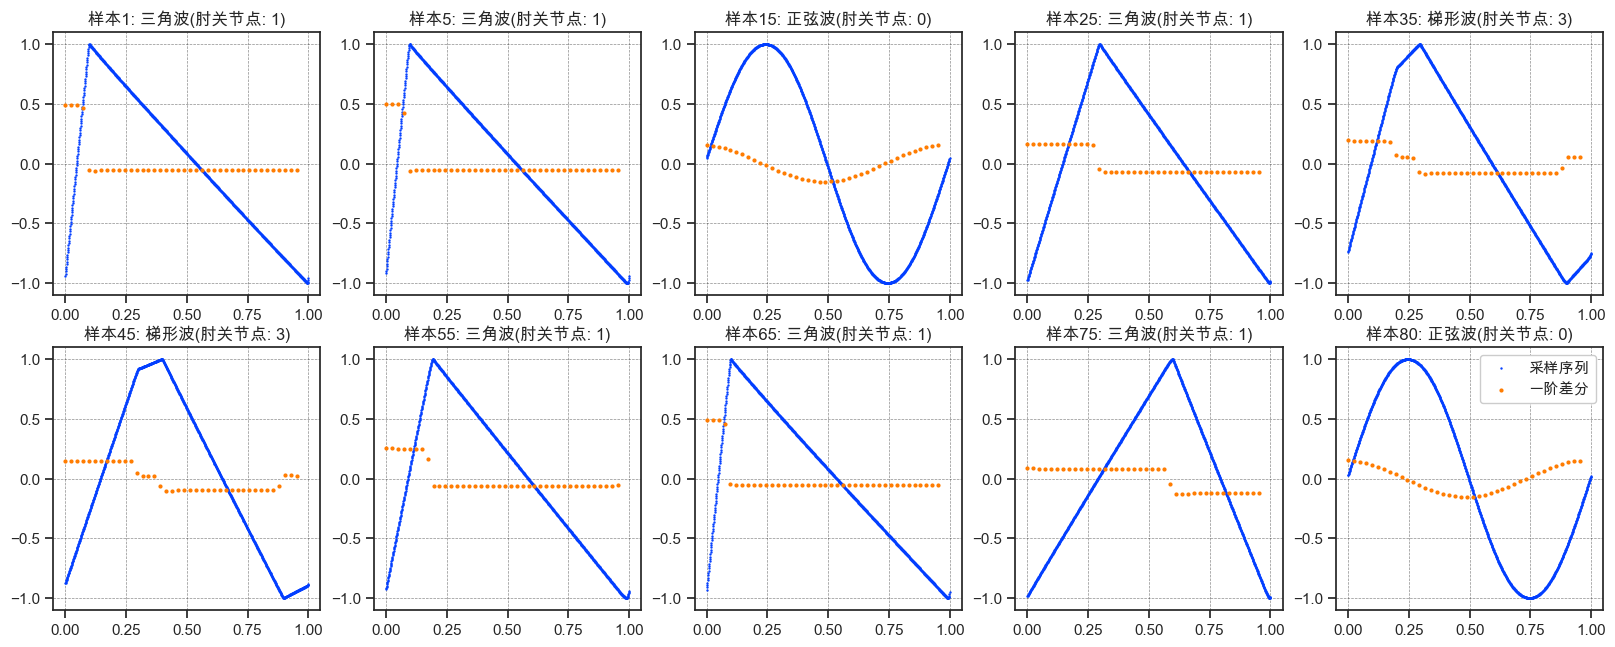

In [15]:
xs = np.linspace(0, 1, 1024)
fig, axes = plt.subplots(2, 5, figsize=(20, 7.5))
for i, ax in zip([1, 5, 15, 25, 35, 45, 55, 65, 75, 80], axes.flatten()):
    sequence = test_df.iloc[i-1]['flux_density']
    sequence = np.array([float(x) for x in sequence])  # convert each element to float and then to numpy array
    first_derivative = np.diff(sequence[::25])
    ax.scatter(xs, sequence, label='采样序列', s=0.5)
    ax.scatter(xs[::step][:-1], first_derivative, label='一阶差分', s=4)
    ax.set_title(f'样本{i}: {type2name[test_df.iloc[i-1]["励磁波形"]]}(肘关节点: {break_counter(sequence)})')
plt.legend()
plt.savefig('figures/p1-res-demo.pdf', bbox_inches='tight')

## 阈值参数确认

In [16]:
result = {'eps': [], 'type_waveform': [], 'accuracy': []}

thresholds = np.arange(0.01, 0.2, 0.01)
for eps in thresholds:
    correct_agg = 0
    total_agg = 0
    for type_waveform in ['正弦波', '三角波', '梯形波']:
        temp = df[df['type_waveform'] == type_waveform]
        temp['type_waveform_predicted'] = temp['flux_density'].apply(
            lambda x: type2name.get(counter2type.get(break_counter(x, step=25, eps=eps), np.nan), '未定义'))
        correct_count = (temp['type_waveform_predicted'] == temp['type_waveform']).sum()
        total_count = len(temp)
        accuracy = correct_count / total_count
        correct_agg += correct_count
        total_agg += total_count
        result['eps'].append(eps)
        result['type_waveform'].append(type_waveform)
        result['accuracy'].append(accuracy)
    result['eps'].append(eps)
    result['type_waveform'].append('总体情况')
    result['accuracy'].append(correct_agg / total_agg)

df_val = pd.DataFrame(result)

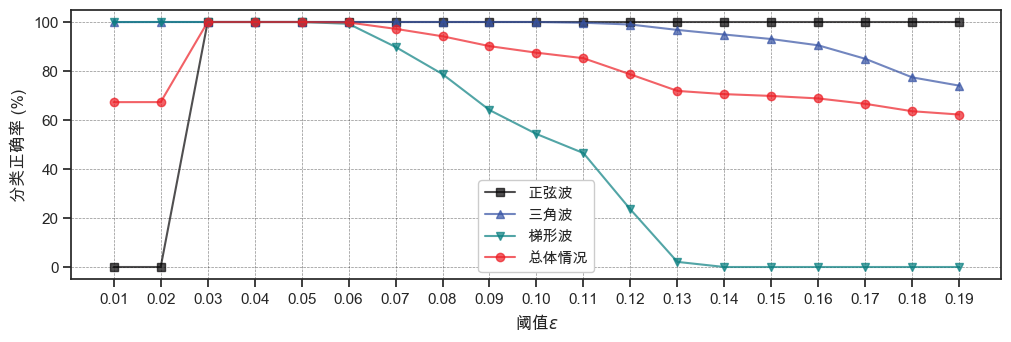

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3.5))
markers = ['s', '^', 'v', 'o']
colors = ['#060506', '#3753a4', '#097f80', '#ed1e25']
for i, type_waveform in enumerate(['正弦波', '三角波', '梯形波', '总体情况']):
    ax.plot(df_val[df_val['type_waveform'] == type_waveform]['eps'],
            df_val[df_val['type_waveform'] == type_waveform]['accuracy'] * 100,  # convert accuracy to percentage
            label=type_waveform, marker=markers[i], alpha=0.7, color=colors[i])
ax.set_xlabel('阈值$\epsilon$')
ax.set_ylabel('分类正确率 (%)')  # change y-axis label to percentage
plt.legend()
plt.xticks(thresholds)
plt.savefig('figures/p1-acc.pdf', bbox_inches='tight')

## 测试集数据分布结果

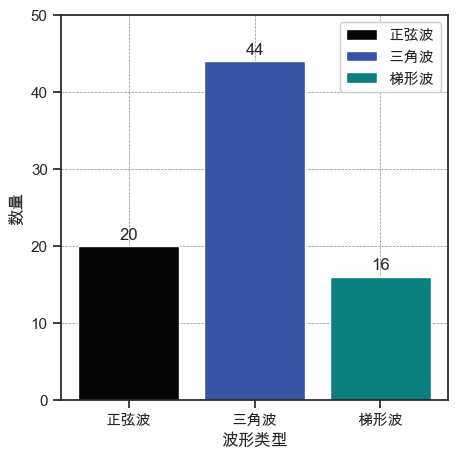

In [18]:
waveform_counts = test_df['励磁波形'].value_counts().sort_index()

hatches = ['', '', '']

plt.figure(figsize=(5, 5))
bars = plt.bar(waveform_counts.index, waveform_counts.values, color=colors[:3], hatch=hatches, label=['正弦波', '三角波', '梯形波'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.xlabel('波形类型')
plt.ylabel('数量')
# plt.title('磁奖波形类型的分布')
plt.xticks([1, 2, 3], ['正弦波', '三角波', '梯形波'])
plt.ylim(0, 50)
plt.legend()
plt.savefig('figures/p1-res-1.pdf', bbox_inches='tight')

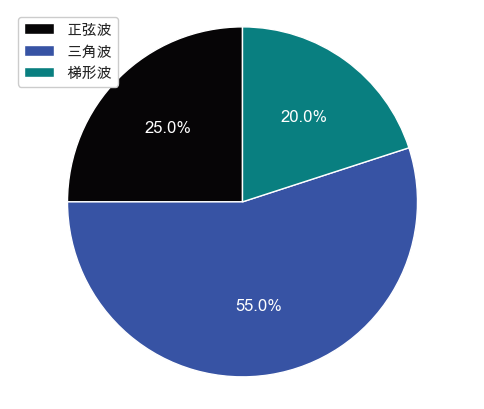

In [19]:
plt.figure(figsize=(6, 5))
labels = ['正弦波', '三角波', '梯形波']
plt.pie(waveform_counts, labels=labels, autopct=lambda p: '{:.1f}%'.format(p), colors=colors[:3], startangle=90, textprops={'color': 'white'})
plt.legend(labels, loc="best")
plt.axis('equal')  # make the pie chart circular
plt.savefig('figures/p1-res-2.pdf', bbox_inches='tight')